In [1]:
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import csv
import re
from datetime import datetime

import os.path
from os import path
import time

# import sklearn
# import scipy

# from sklearn.naive_bayes import GaussianNB
# import lightgbm as lightgbm
# from xgboost import XGBClassifier
# import keras

# Get Started
# https://github.com/Refinitiv-API-Samples/Article.EikonDataAPI.DotNet.Library
# API limits
# https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/documentation?content=49692&type=documentation_item
import eikon as ek 

from pylab import rcParams
plt.rcParams['figure.figsize'] = 16, 8

In [2]:
fontsize_reg = 12
fontsize_title = 16
from pylab import rcParams
rcParams['figure.facecolor'] = '1'
rcParams['figure.figsize'] = [8.0, 3.5]
rcParams['figure.dpi'] = 80
rcParams['savefig.dpi'] = 600

rcParams['font.size'] = 12
rcParams['legend.fontsize'] = 'large'
rcParams['figure.titlesize'] = 'large'

In [3]:
# Зададим path для папки проекта и для папок файлов
path_project_folder = 'C:/DAN/t_systems/trade_project/'
folder_name_headlines = 'backup_headlines/'
folder_name_logger = 'logger/'

In [4]:
# зададим API ключ
ek.set_app_key('ccebd1ff788d4574818be93e35c4741925ac214e')

In [5]:
rics_german_df = pd.read_excel(path_project_folder + 'rics_german_excel.xlsx')
sort_cols = ['DAX', 'German_telecom', 'Company Market Cap']
rics_german_df = rics_german_df.sort_values(by=sort_cols, ascending=False) # .reset_index(drop=True)
rics_german_df.index = range(0, len(rics_german_df))
rics_german_df

,ric,Company Common Name,Country of Exchange,Primary Country of Risk,TRBC Industry Group Name,TRBC Industry Name,Price Close,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,Germany,Germany,Telecommunications Services,Integrated Telecommunications Services,18.032030,8.580246e+10,1,1
1,SAPG.DE,SAP SE,Germany,Germany,Software & IT Services,Software,122.335901,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,Germany,Germany,Consumer Goods Conglomerates,Consumer Goods Conglomerates,139.347250,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,Germany,Germany,Insurance,Multiline Insurance & Brokers,235.534278,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,Germany,Germany,Automobiles & Auto Parts,Auto & Truck Manufacturers,182.653284,9.619011e+10,1,0
...,...,...,...,...,...,...,...,...,...,...
1486,IXM0392.DE,MSCI Pac ex Jap ETF,Germany,NaN,NaN,NaN,164.045417,NaN,0,0
1487,IXM0402.DE,MSCI Canada ETF,Germany,NaN,NaN,NaN,147.258410,NaN,0,0
1488,IXM0422.DE,MSCI USA ETF,Germany,NaN,NaN,NaN,368.704250,NaN,0,0
1489,IXM0432.DE,MSCI Jap ETF,Germany,NaN,NaN,NaN,179.058138,NaN,0,0


In [6]:
condition_german = rics_german_df['Country of Exchange'] == 'Germany'
condition_telecom = rics_german_df['TRBC Industry Group Name'] == 'Telecommunications Services'
rics_german_telekom_df = rics_german_df[condition_german & condition_telecom]
rics_german_telekom_df[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
0,DTEGn.DE,Deutsche Telekom AG,8.580246e+10,1,1
27,O2Dn.DE,Telefonica Deutschland Holding AG,8.088962e+09,0,1
28,UTDI.DE,United Internet AG,7.962405e+09,0,1
29,DRIG.DE,1&1 Drillisch AG,4.331541e+09,0,1
30,FNTGn.DE,freenet AG,2.614030e+09,0,1
31,TC1n.DE,Tele Columbus AG,3.688837e+08,0,1
32,NFN.DE,NFON AG,3.245050e+08,0,1
33,E4CG.DE,Ecotel Communication AG,3.558930e+07,0,1
34,PH6.F,Philion SE,2.065664e+05,0,1


In [7]:
condition_dax = (rics_german_df['DAX'] == 1) & (rics_german_df['German_telecom'] != 1)
rics_dax = rics_german_df[condition_dax]
rics_dax[['ric', 'Company Common Name', 'Company Market Cap', 'DAX', 'German_telecom']]

,ric,Company Common Name,Company Market Cap,DAX,German_telecom
1,SAPG.DE,SAP SE,1.501916e+11,1,0
2,SIEGn.DE,Siemens AG,1.183675e+11,1,0
3,ALVG.DE,Allianz SE,9.704549e+10,1,0
4,VOWG_p.DE,Volkswagen AG,9.619011e+10,1,0
5,DAIGn.DE,Daimler AG,7.532200e+10,1,0
6,BASFn.DE,BASF SE,7.222737e+10,1,0
7,ADSGn.DE,Adidas AG,7.062461e+10,1,0
8,DPWGn.DE,Deutsche Post AG,5.932596e+10,1,0
9,BMWG.DE,Bayerische Motoren Werke AG,5.780708e+10,1,0
10,BAYGn.DE,Bayer AG,5.621811e+10,1,0


In [8]:
def get_name_of_latest_file_in_folder(folder_name):
    files_creation_dates = pd.DataFrame(data = [], columns=[
        "folder_name", "file_name", "num_time", "str_time"
    ])

    files_creation_dates['file_name'] = os.listdir(folder_name)
    files_creation_dates['folder_name'] = folder_name
    files_creation_dates['file_folder_and_name'] = files_creation_dates['folder_name'] + files_creation_dates['file_name']
    files_creation_dates
    for i in range(0, len(files_creation_dates)):
        file_folder_and_name = files_creation_dates['file_folder_and_name'][i]
        files_creation_dates['num_time'][i] = os.path.getctime(file_folder_and_name)
        files_creation_dates['str_time'][i] = time.ctime(os.path.getctime(file_folder_and_name))

    most_latest_file_dir = files_creation_dates.sort_values(by=['num_time'], ascending=False)['file_folder_and_name'].iloc[0]
    
    return most_latest_file_dir

In [9]:
# Создадим df, в который будем сохранять вообще все новости.

# Можем создать пустой df, куда будем добавлять все новости
# all_headlines_df = pd.DataFrame(data = [], columns=["ric", "versionCreated", "headline", "storyId", "sourceCode", "story"])

# Но если мы уже сохраняли файл, достанем самый свежий из папки
most_latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_headlines)
all_headlines_df = pd.read_csv(most_latest_file, sep='~')
all_headlines_df['versionCreated'] = pd.to_datetime(all_headlines_df['versionCreated'])
print(all_headlines_df.shape, most_latest_file)

(77560, 6) C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-07_v8.csv


In [10]:
# Создадим подобие logger'а 

# quasi_logger = pd.DataFrame(data = [], columns=[
#     'ric_i', 'ric_now', 'headlines_slice_i', 'headlines_number',
#     'up_to_date_ric', 'story_i', 'story_id_now', 'story_is_success', 
#     'date_time',
# ])

# Так как у нас уже есть созданный logger, подгрузим его
most_latest_file = get_name_of_latest_file_in_folder(path_project_folder + folder_name_logger)
quasi_logger = pd.read_csv(most_latest_file, sep=';')
print(quasi_logger.shape, most_latest_file)

(53824, 9) C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-07_v8.csv


In [11]:
# Проверим, содержит ли all_headlines_df наш текущий ric
def set_value_of_up_to_date_ric(
        ric_now, # ric to check of existence in df
        df_with_news_to_check,
        column_name_with_rics = 'ric',
        column_name_with_dates = 'versionCreated'):
    """
    This function is checking the existance of ric in chosen df.
    If some news are in df, then function returns the oldest date in df.
    If no news are in df, then function returns 'None' for ek.get_news_headlines.
    """

    is_this_ric_in_all = ric_now in list(df_with_news_to_check[column_name_with_rics])
    print()
    print('is_this_ric_in_all:', is_this_ric_in_all, end=' ')
    if is_this_ric_in_all:
        # Если в нашем датасете присутствует этот ric,
        # то продолжаем по нему выгружать, берём мин имеющуюся дату.
        up_to_date_ric = str(df_with_news_to_check[df_with_news_to_check[column_name_with_rics] == ric_now][column_name_with_dates].min())
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
    else:
        # None означает, что метод ek.get_news_headlines возьмёт текущий момент времени.
        up_to_date_ric = None
        print('  up_to_date_ric:', up_to_date_ric, end=' ')
        
    return up_to_date_ric

In [12]:
def get_news_headlines_with_some_tries(
        ric_now,
        headlines_count_to_request,
        up_to_date_ric,
        max_num_tries=5):
    """
    We trying to get df with headlines from eikon API with several tries
    """
    
    tries_num = 0
    while tries_num < max_num_tries:
        try:
            news_get_df = ek.get_news_headlines(
                query=ric_now,
                count=headlines_count_to_request,
                date_to=up_to_date_ric
            )
            print('got successfully', end=' ')
            break
        except Exception as e:
            print()
            print('Error when trying to get news headlines', tries_num)
            print(e)
            time.sleep(5)
            tries_num = tries_num + 1

    print('news_get_df.shape:', news_get_df.shape[0])

    return news_get_df

In [13]:
def prepare_headlines_df_to_adding_news_story(
        ric_now,
        news_get_df):
    """
    Now: news_get_df is collected df from ek.get_news_headlines method.
    And we want to add news story (full news text) to that df.
    So we should prepare that df for iterations with ek.get_news_story method.
    For that puspose we should add ric and story columns,
    and change the column name with headlines from text to headlines.
    """
    
    news_get_df = news_get_df.reset_index(drop=True) # чтобы юзать .loc()
    news_get_df['ric'] = ric_now
    news_get_df['story'] = np.nan
    news_get_df['headline'] = news_get_df['text']
    news_get_df = news_get_df.drop(columns=['text'])
    
    return news_get_df

In [14]:
def adding_news_stories_to_df_with_headlines(
        news_get_df,
        quasi_logger,
        ric_i,
        ric_now,
        headlines_slice_i,
        headlines_number,
        up_to_date_ric,
        col_name_with_story_id = 'storyId'):
    """
    The function adds full text news story to df with headlines using storyId.
    The function just prints the error in a case of error (they are rare).
    In any case the function logs results of API request to logger df.
    """

    for story_i in range(0, len(news_get_df)): # range(0, len(news_get_df))
        story_id_now = news_get_df['storyId'][story_i]

        try:
            story_now = ek.get_news_story(story_id_now)
            # Удалим из истории все тильды на всякий случай, будет sep='~'
            story_now = story_now.replace("~", "!tilda!")
            # Внесём выкаченную историю в df
            news_get_df.loc[story_i, 'story'] = story_now
            # Пометим, что мы успешно выкачали текст новости
            story_is_success = True
            print(story_i, end='; ')

        except Exception as e:
            story_is_success = False
            # Заменим NA на текст ошибки
            news_get_df.loc[story_i, 'story'] = 'error_when_trying_to_collect_story'
            # Выведем story с ошибкой
            print() # e.message
            print(
                'STORY IS OK:', story_is_success, 
                '  ric_now:', ric_now, # input to function
                '  ric_i:', ric_i, # input to function
                '  story_i:', story_i
                )
            print(e)
            time.sleep(5)

        finally:
            # В любом случае внесём в наш квази-логгер наблюдение story.
            quasi_logger = quasi_logger.append({
                "ric_i": ric_i, # input to function
                "ric_now": ric_now, # input to function
                "headlines_slice_i": headlines_slice_i, # input to function
                "headlines_number": headlines_number, # input to function
                "up_to_date_ric": up_to_date_ric, # input to function
                "story_i": story_i,
                "story_id_now": story_id_now,
                "story_is_success": story_is_success,
                "date_time": str(datetime.today())
            }, ignore_index = True)
    # At that moment the df has full text of news in col story
    return news_get_df, quasi_logger

In [15]:
def save_file_as_new_file_without_replacing(
        path_project_folder,
        folder_name_to_save,
        file_to_save,
        file_short_name_add_to_path):
    """
    Save the file to selected folder without replacing,
    but changing file name as a number of version at date now
    """
    # Сохраним версию all_headlines_df со всеми новостями
    # Подберём такое название, которого нет в dir, чтобы не переписывать файл.
    file_version = 1
    folder_name = path_project_folder + folder_name_to_save
    date_now = datetime.today().strftime("%Y-%m-%d")
    file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    while file_name in os.listdir(folder_name):
        file_name = file_short_name_add_to_path + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
        file_version = file_version + 1
    # C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
    file_path = folder_name + file_name
    file_to_save.to_csv(file_path, sep = '~', index=False)
    print(file_path)

In [35]:
# Зададим, по какому df мы будет итерировать ric компании (её код на бирже).
rics_to_loop_df = rics_dax
rics_to_loop_df = rics_to_loop_df.reset_index(drop=True) # чтобы юзать .loc()

# Зададим переменную, котролирующую количество выгружаемых за раз заголовков
headlines_count_to_request = 100

# Необходимо задать переменную до цикла как 100, далее она будет изменяться
headlines_number = 100

# Первый цикл будет итерировать компании.
for ric_i in range(18, len(rics_to_loop_df)): # range(0, len(rics_to_loop_df))
    
    # Зададим переменную, которая скажет, какой сейчас итерируется ric.
    ric_now = rics_to_loop_df.loc[ric_i, "ric"]
    print(ric_i, ric_now)
    
    # Цикл, который прогоняет запросы заголовков.
    # Зададим для него параметр. Прибавим +1, если исчерпали новости.
    last_headlines_request = False
    # Будем вести счёт итерацию цикла While для выгрузки заголовков
    headlines_slice_i = 0
    # Для выкачивания заголовков нужно задать дату, до которой делаем запрос.
    # Если такого ric нет в all_headlines_df со всеми новостями,
    # то не будет задавать дату, до которой выкачивать заголовки.
    # Если такой ric есть в all_headlines_df со всеми новостями,
    # то возьмём минимальную дату из all_headlines_df со всеми новостями
    while not last_headlines_request:
        
        # That function returns the param for ek.get_news_headlines method
        # That param means the datetime slice of news to be collected
        up_to_date_ric = set_value_of_up_to_date_ric(
            ric_now=ric_now,
            df_with_news_to_check=all_headlines_df,
            column_name_with_rics='ric',
            column_name_with_dates='versionCreated'
        )
        
        # That function returns df with news headlines after several tries
        news_get_df = get_news_headlines_with_some_tries(
            max_num_tries=5,
            ric_now=ric_now,
            headlines_count_to_request=headlines_count_to_request,
            up_to_date_ric=up_to_date_ric
        )
        
        # Some df changes before adding full news text to that df
        news_get_df = prepare_headlines_df_to_adding_news_story(
            ric_now, news_get_df)
        
        # Adding full text of news (stories) to df with headlines
        news_get_df, quasi_logger = adding_news_stories_to_df_with_headlines(
            news_get_df,
            quasi_logger,
            ric_i,
            ric_now,
            headlines_slice_i,
            headlines_number,
            up_to_date_ric,
            col_name_with_story_id = 'storyId')
        
        # If at that moment news_get_df has less than 100 news,
        # than it means we have exhausted news for that ric because of dates limitation.
        # And we need to change ric_now that we iterate.
        headlines_number = news_get_df.shape[0]
        if headlines_number < 100:
            last_headlines_request = True
        
        headlines_slice_i = headlines_slice_i + 1
        
        # At that moment news_get_df has the slice with headlines & full-text.
        # Let's add that slice to all_headlines_df that has all news.
        all_headlines_df = all_headlines_df.append(news_get_df, ignore_index = True)
        print()
        print(str(datetime.today()), ric_now, 
              ' ric_i:', ric_i,
              ' headline_slice_i:', headlines_slice_i,
              ' headline_number:', headlines_number,
              ' not null:', news_get_df['story'].notna().sum(),
              up_to_date_ric)
        
        # End of headlines iterations for one selected ric
    
    # Save the version of all_headlines_df at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_headlines,
        file_to_save=all_headlines_df,
        file_short_name_add_to_path='all_headlines_df')
    
    # Save the version of quasi_logger at every ric iteration
    save_file_as_new_file_without_replacing(
        path_project_folder=path_project_folder,
        folder_name_to_save=folder_name_logger,
        file_to_save=quasi_logger,
        file_short_name_add_to_path='quasi_logger')

18 FMEG.DE

is_this_ric_in_all: True   up_to_date_ric: 2019-10-07 06:57:28.618000+00:00 got successfully news_get_df.shape: 0

2021-01-08 02:10:31.122830 FMEG.DE  ric_i: 18  headline_slice_i: 1  headline_number: 0  not null: 0 2019-10-07 06:57:28.618000+00:00
C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-08_v2.csv
C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-08_v1.csv
19 DBKGn.DE

is_this_ric_in_all: True   up_to_date_ric: 2020-11-18 08:00:25.006000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 02:13:48.150554 DBKGn.DE  ric_i: 19  headline_slice_i: 1 

2021-01-08 02:45:41,671 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 02:45:41,672 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 67
'NoneType' object has no attribute 'replace'
68; 69; 70; 71; 72; 73; 74; 75; 76; 

2021-01-08 02:46:29,176 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 02:46:29,177 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 77
'NoneType' object has no attribute 'replace'
78; 79; 80; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 81
'NoneType' object has no attribute 'replace'
82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 02:47:25.843579 DBKGn.DE  ric_i: 19  headline_slice_i: 10  headline_number: 100  not null: 100 2020-09-22 16:57:27.043000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-09-21 07:02:27+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 19
'NoneType' object has no attribute 'replace'
20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 

2021-01-08 02:50:58,654 P[4228] [MainThread 11800] Error code 518 | Server Error: Server Side Timeout - Do Not Resubmit
2021-01-08 02:50:58,655 P[4228] [MainThread 11800] HTTP request failed: EikonError-Server Error: Server Side Timeout - Do Not Resubmit



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 78
'NoneType' object has no attribute 'replace'
79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 02:51:42.378709 DBKGn.DE  ric_i: 19  headline_slice_i: 11  headline_number: 100  not null: 100 2020-09-21 07:02:27+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-09-14 22:00:00+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 02:55:33.428979 DBKGn.DE  ric_i: 19  headline_slice_i: 12  headline_number: 100  not null: 100 2020-09-14 22:00:00+00:00

is_this_ric_in_all: True   up_to_date_

2021-01-08 03:16:19,885 P[4228] [MainThread 11800] Backend error. 503 Service Unavailable
2021-01-08 03:16:19,886 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 57
'NoneType' object has no attribute 'replace'
58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 03:19:02.518954 DBKGn.DE  ric_i: 19  headline_slice_i: 18  headline_number: 100  not null: 100 2020-07-29 06:30:07+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-07-29 05:01:24.382000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 

2021-01-08 03:19:22,872 P[4228] [MainThread 11800] Backend error. 503 Service Unavailable
2021-01-08 03:19:22,873 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 9
'NoneType' object has no attribute 'replace'
10; 

2021-01-08 03:19:31,509 P[4228] [MainThread 11800] Backend error. 503 Service Unavailable
2021-01-08 03:19:31,510 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 11
'NoneType' object has no attribute 'replace'


2021-01-08 03:19:36,757 P[4228] [MainThread 11800] Backend request failed. Post http:/Apps/NewsServices/story: read tcp 10.19.177.178:55213->10.19.243.24:80: read: connection reset by peer
2021-01-08 03:19:36,758 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend request failed. Post http:/Apps/NewsServices/story: read tcp 10.19.177.178:55213->10.19.243.24:80: read: connection reset by peer



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 12
'NoneType' object has no attribute 'replace'
13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 70
'NoneType' object has no attribute 'replace'
71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 03:22:17.871853 DBKGn.DE  ric_i: 19  headline_slice_i: 19  headline_number: 100  not null: 100 2020-07-29 05:01:24.382000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-07-23 02:16:44.765000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 8
'NoneType' object has no attribute 'replace'
9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 

2021-01-08 03:31:24,029 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 03:31:24,029 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 93
'NoneType' object has no attribute 'replace'
94; 95; 96; 97; 98; 99; 
2021-01-08 03:31:45.905797 DBKGn.DE  ric_i: 19  headline_slice_i: 22  headline_number: 100  not null: 100 2020-07-11 06:02:32.491000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-07-07 18:22:15.057000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 

2021-01-08 03:32:07,705 P[4228] [MainThread 11800] Error code 500 | Server Error: {"code":500,"message":"read ECONNRESET","statusMessage":"Internal Server Error"}
2021-01-08 03:32:07,705 P[4228] [MainThread 11800] HTTP request failed: EikonError-Server Error: {"code":500,"message":"read ECONNRESET","statusMessage":"Internal Server Error"}


9; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 10
'NoneType' object has no attribute 'replace'
11; 12; 13; 

2021-01-08 03:32:17,746 P[4228] [MainThread 11800] Error code 500 | Server Error: {"code":500,"message":"read ECONNRESET","statusMessage":"Internal Server Error"}
2021-01-08 03:32:17,747 P[4228] [MainThread 11800] HTTP request failed: EikonError-Server Error: {"code":500,"message":"read ECONNRESET","statusMessage":"Internal Server Error"}



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 14
'NoneType' object has no attribute 'replace'
15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 60
'NoneType' object has no attribute 'replace'
61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 

2021-01-08 03:35:19,088 P[4228] [MainThread 11800] Error code 500 | Server Error: {"code":500,"message":"getaddrinfo ENOTFOUND plnp-erpcprp07.int.thomsonreuters.com plnp-erpcprp07.int.thomsonreuters.com:443","statusMessage":"Internal Server Error"}
2021-01-08 03:35:19,089 P[4228] [MainThread 11800] HTTP request failed: EikonError-Server Error: {"code":500,"message":"getaddrinfo ENOTFOUND plnp-erpcprp07.int.thomsonreuters.com plnp-erpcprp07.int.thomsonreuters.com:443","statusMessage":"Internal Server Error"}



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 72
'NoneType' object has no attribute 'replace'
73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 03:36:19.681512 DBKGn.DE  ric_i: 19  headline_slice_i: 23  headline_number: 100  not null: 100 2020-07-07 18:22:15.057000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-07-06 15:47:15.736000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 

2021-01-08 03:37:11,759 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 03:37:11,759 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 19
'NoneType' object has no attribute 'replace'
20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 03:39:36.128879 DBKGn.DE  ric_i: 19  headline_slice_i: 24  headline_number: 100  not null: 100 2020-07-06 15:47:15.736000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-06-30 09:26:43+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 

2021-01-08 03:40:24,903 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 03:40:24,904 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 14
'NoneType' object has no attribute 'replace'
15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 03:43:20.793386 DBKGn.DE  ric_i: 19  headline_slice_i: 25  headline_number: 100  not null: 100 2020-06-30 09:26:43+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-06-19 10:10:30+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 

2021-01-08 03:58:56,601 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 03:58:56,602 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 54
'NoneType' object has no attribute 'replace'
55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:00:14.298058 DBKGn.DE  ric_i: 19  headline_slice_i: 30  headline_number: 100  not null: 100 2020-05-27 05:05:36+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-05-20 23:16:58.043000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:04:11.047001 DBKGn.DE  ric_i: 19  headline_slice_i: 31

2021-01-08 04:13:19,824 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 04:13:19,825 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 41
'NoneType' object has no attribute 'replace'
42; 43; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 44
'NoneType' object has no attribute 'replace'
45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 80
'NoneType' object has no attribute 'replace'
81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:15:42.865644 DBKGn.DE  ric_i: 19  headline_slice_i: 34  headline_number: 100  not null: 100 2020-05-07 13:06:14.065000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-30 11:08:50.649000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 

2021-01-08 04:16:06,486 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 04:16:06,488 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 11
'NoneType' object has no attribute 'replace'
12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:19:20.577009 DBKGn.DE  ric_i: 19  headline_slice_i: 35  headline_number: 100  not null: 100 2020-04-30 11:08:50.649000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-29 05:15:41+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 7

2021-01-08 04:25:19,123 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 04:25:19,124 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 8
'NoneType' object has no attribute 'replace'
9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 93
'NoneType' object has no attribute 'replace'
94; 95; 96; 97; 98; 99; 
2021-01-08 04:28:16.684765 DBKGn.DE  ric_i: 19  headline_slice_i: 37  headline_number: 100  not null: 100 2020-04-28 08:42:33+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-26 19:52:33+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46;

2021-01-08 04:33:42,040 P[4228] [MainThread 11800] UDF Core request failed. Service Temporarily Unavailable
2021-01-08 04:33:42,041 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Service Temporarily Unavailable



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 68
'NoneType' object has no attribute 'replace'
69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:34:48.993122 DBKGn.DE  ric_i: 19  headline_slice_i: 39  headline_number: 100  not null: 100 2020-04-20 15:27:22+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-04-03 16:03:10+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 

2021-01-08 04:35:28,229 P[4228] [MainThread 11800] No datapoint found with provided name
2021-01-08 04:35:28,230 P[4228] [MainThread 11800] HTTP request failed: EikonError-No datapoint found with provided name



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 8
'NoneType' object has no attribute 'replace'
9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:38:45.459832 DBKGn.DE  ric_i: 19  headline_slice_i: 40  headline_number: 100  not null: 100 2020-04-03 16:03:10+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-03-31 08:10:50+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73

2021-01-08 04:42:31,430 P[4228] [MainThread 11800] Backend error. 503 Service Unavailable
2021-01-08 04:42:31,431 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 21
'NoneType' object has no attribute 'replace'
22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 04:45:39.639098 DBKGn.DE  ric_i: 19  headline_slice_i: 42  headline_number: 100  not null: 100 2020-03-24 12:35:37+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-03-20 07:13:43.756000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 
STORY IS OK: Fal

2021-01-08 05:54:19,309 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 05:54:19,310 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 99
'NoneType' object has no attribute 'replace'

2021-01-08 05:54:24.340884 DBKGn.DE  ric_i: 19  headline_slice_i: 61  headline_number: 100  not null: 100 2019-12-03 15:42:56+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-25 20:02:13.129000+00:00 got successfully news_get_df.shape: 100


2021-01-08 05:54:30,442 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 05:54:30,443 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 0
'NoneType' object has no attribute 'replace'
1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 26
'NoneType' object has no attribute 'replace'
27; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 28
'NoneType' object has no attribute 'replace'
29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 05:57:50.465107 DBKGn.DE  ric_i: 19  headline_slice_i: 62  headline_number: 100  not null: 100 2019-11-25 20:02:13.129000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-18 11:26:16+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 


2021-01-08 05:58:53,303 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 05:58:53,304 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 28
'NoneType' object has no attribute 'replace'
29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 

2021-01-08 06:00:58,295 P[4228] [MainThread 11800] Error code 518 | Server Error: Server Side Timeout - Do Not Resubmit
2021-01-08 06:00:58,296 P[4228] [MainThread 11800] HTTP request failed: EikonError-Server Error: Server Side Timeout - Do Not Resubmit



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 69
'NoneType' object has no attribute 'replace'
70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 84
'NoneType' object has no attribute 'replace'
85; 86; 87; 88; 89; 

2021-01-08 06:01:40,969 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 06:01:40,970 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 90
'NoneType' object has no attribute 'replace'
91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 06:02:02.752890 DBKGn.DE  ric_i: 19  headline_slice_i: 63  headline_number: 100  not null: 100 2019-11-18 11:26:16+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-12 12:35:15.486000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 46
'NoneType' object has no attribute 'replace'
47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 
STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 89
'NoneType' object has no attribute 'replace'
90; 91; 92; 93; 94; 95; 96; 97; 98; 
ST

2021-01-08 06:26:25,491 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 06:26:25,492 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: DBKGn.DE   ric_i: 19   story_i: 50
'NoneType' object has no attribute 'replace'
51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 06:28:08.341429 DBKGn.DE  ric_i: 19  headline_slice_i: 70  headline_number: 100  not null: 100 2019-10-16 11:39:02+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-10-11 08:32:57.844000+00:00 got successfully news_get_df.shape: 68
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 
2021-01-08 06:30:34.970530 DBKGn.DE  ric_i: 19  headline_slice_i: 71  headline_number: 68  not null: 68 2019-10-11 08:32:57.844000+00:00
C:/DAN/t_systems/trade_project/backup_headli

2021-01-08 06:48:11,676 P[4228] [MainThread 11800] Backend error. Failed to deserialize backend response. Expected valid JSON. Error: invalid character 'I' looking for beginning of value
2021-01-08 06:48:11,677 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. Failed to deserialize backend response. Expected valid JSON. Error: invalid character 'I' looking for beginning of value



STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 16
'NoneType' object has no attribute 'replace'
17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 
STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 76
'NoneType' object has no attribute 'replace'
77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 06:51:15.047731 MRCG.DE  ric_i: 20  headline_slice_i: 5  headline_number: 100  not null: 100 2020-08-06 05:05:14.990000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-07-01 13:03:24+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53

2021-01-08 07:08:52,034 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 07:08:52,035 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 87
'NoneType' object has no attribute 'replace'
88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 07:09:37.554362 MRCG.DE  ric_i: 20  headline_slice_i: 9  headline_number: 100  not null: 100 2020-04-07 12:03:42.498000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-03-13 12:01:06.689000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 
STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 28
'NoneType' object has no attribute 'replace'
29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 
STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 41
'NoneType' object has no attribute 'replace'
42; 

2021-01-08 07:12:21,445 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 07:12:21,446 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 43
'NoneType' object has no attribute 'replace'
44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 07:15:02.027285 MRCG.DE  ric_i: 20  headline_slice_i: 10  headline_number: 100  not null: 100 2020-03-13 12:01:06.689000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-02-21 23:07:52.643000+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 07:18:58

2021-01-08 07:19:22,785 P[4228] [MainThread 11800] Backend error. 404 Not Found
2021-01-08 07:19:22,786 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 404 Not Found



STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 8
'NoneType' object has no attribute 'replace'
9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 
STORY IS OK: False   ric_now: MRCG.DE   ric_i: 20   story_i: 87
'NoneType' object has no attribute 'replace'
88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 07:23:55.588802 MRCG.DE  ric_i: 20  headline_slice_i: 12  headline_number: 100  not null: 100 2019-12-19 13:03:38.217000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2019-11-12 13:04:02+00:00 got successfully news_get_df.shape: 72
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 

2021-01-08 07:42:42,126 P[4228] [MainThread 11800] Backend error. 503 Service Unavailable
2021-01-08 07:42:42,127 P[4228] [MainThread 11800] HTTP request failed: EikonError-Backend error. 503 Service Unavailable



STORY IS OK: False   ric_now: HEIG.DE   ric_i: 21   story_i: 86
'NoneType' object has no attribute 'replace'
87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 07:43:11.669745 HEIG.DE  ric_i: 21  headline_slice_i: 4  headline_number: 100  not null: 100 2020-07-15 04:49:25+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-06-23 06:01:42+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 
STORY IS OK: False   ric_now: HEIG.DE   ric_i: 21   story_i: 28
'NoneType' object has no attribute 'replace'
29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 
STORY IS OK: False   ric_now: HEIG.DE   ric_i: 21   story_i: 78
'NoneType' object has no attribute 'replace'
79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98;

2021-01-08 08:24:28,107 P[4228] [MainThread 11800] UDF Core request failed. Gateway Time-out
2021-01-08 08:24:28,108 P[4228] [MainThread 11800] HTTP request failed: EikonError-UDF Core request failed. Gateway Time-out



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 45
'NoneType' object has no attribute 'replace'
46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 08:26:24.248640 CBKG.DE  ric_i: 22  headline_slice_i: 5  headline_number: 100  not null: 100 2020-10-16 03:10:49.482000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-09-28 06:01:56+00:00 got successfully news_get_df.shape: 100
0; 1; 2; 3; 4; 5; 6; 7; 8; 9; 10; 11; 12; 13; 14; 15; 16; 17; 18; 19; 20; 21; 22; 23; 24; 25; 26; 27; 28; 29; 30; 31; 32; 33; 34; 35; 36; 37; 38; 39; 40; 41; 42; 43; 44; 45; 46; 47; 48; 49; 50; 51; 52; 53; 54; 55; 56; 57; 58; 59; 60; 61; 62; 63; 64; 65; 66; 67; 68; 69; 70; 71; 72; 73; 74; 75; 76; 77; 78; 79; 80; 81; 82; 83; 84; 85; 86; 87; 88; 89; 90; 91; 92; 93; 94; 95; 96; 97; 98; 99; 
2021-01-08 08:29:52.494967 CBKG.DE 

2021-01-08 08:32:16,783 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55664 seconds.
2021-01-08 08:32:16,784 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55664 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 66
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:21,815 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55659 seconds.
2021-01-08 08:32:21,816 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55659 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 67
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:26,849 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55654 seconds.
2021-01-08 08:32:26,851 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55654 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 68
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:31,884 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55649 seconds.
2021-01-08 08:32:31,885 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55649 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 69
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:36,913 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55644 seconds.
2021-01-08 08:32:36,914 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55644 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 70
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:41,940 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55639 seconds.
2021-01-08 08:32:41,940 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55639 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 71
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:46,972 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55634 seconds.
2021-01-08 08:32:46,974 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55634 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 72
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:51,994 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55629 seconds.
2021-01-08 08:32:51,995 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55629 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 73
'NoneType' object has no attribute 'replace'


2021-01-08 08:32:57,025 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55623 seconds.
2021-01-08 08:32:57,026 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55623 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 74
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:02,053 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55618 seconds.
2021-01-08 08:33:02,055 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55618 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 75
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:07,081 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55613 seconds.
2021-01-08 08:33:07,082 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55613 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 76
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:12,112 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55608 seconds.
2021-01-08 08:33:12,114 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55608 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 77
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:17,146 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55603 seconds.
2021-01-08 08:33:17,147 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55603 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 78
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:22,171 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55598 seconds.
2021-01-08 08:33:22,172 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55598 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 79
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:27,203 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55593 seconds.
2021-01-08 08:33:27,204 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55593 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 80
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:32,227 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55588 seconds.
2021-01-08 08:33:32,228 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55588 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 81
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:37,252 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55583 seconds.
2021-01-08 08:33:37,253 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55583 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 82
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:42,288 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55578 seconds.
2021-01-08 08:33:42,289 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55578 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 83
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:47,319 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55573 seconds.
2021-01-08 08:33:47,319 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55573 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 84
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:52,343 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55568 seconds.
2021-01-08 08:33:52,344 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55568 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 85
'NoneType' object has no attribute 'replace'


2021-01-08 08:33:57,368 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55563 seconds.
2021-01-08 08:33:57,368 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55563 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 86
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:02,394 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55558 seconds.
2021-01-08 08:34:02,395 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55558 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 87
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:07,422 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55553 seconds.
2021-01-08 08:34:07,423 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55553 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 88
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:12,448 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55548 seconds.
2021-01-08 08:34:12,448 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55548 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 89
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:17,472 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55543 seconds.
2021-01-08 08:34:17,473 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55543 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 90
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:22,506 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55538 seconds.
2021-01-08 08:34:22,508 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55538 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 91
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:27,536 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55533 seconds.
2021-01-08 08:34:27,537 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55533 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 92
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:32,569 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55528 seconds.
2021-01-08 08:34:32,569 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55528 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 93
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:37,590 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55523 seconds.
2021-01-08 08:34:37,591 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55523 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 94
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:42,622 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55518 seconds.
2021-01-08 08:34:42,622 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55518 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 95
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:47,651 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55513 seconds.
2021-01-08 08:34:47,653 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55513 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 96
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:52,678 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55508 seconds.
2021-01-08 08:34:52,679 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55508 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 97
'NoneType' object has no attribute 'replace'


2021-01-08 08:34:57,709 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55503 seconds.
2021-01-08 08:34:57,710 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55503 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 98
'NoneType' object has no attribute 'replace'


2021-01-08 08:35:02,736 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55498 seconds.
2021-01-08 08:35:02,737 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55498 seconds.



STORY IS OK: False   ric_now: CBKG.DE   ric_i: 22   story_i: 99
'NoneType' object has no attribute 'replace'


2021-01-08 08:35:07,801 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55493 seconds.
2021-01-08 08:35:07,801 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55493 seconds.



2021-01-08 08:35:07.774820 CBKG.DE  ric_i: 22  headline_slice_i: 7  headline_number: 100  not null: 100 2020-09-18 11:14:09.652000+00:00

is_this_ric_in_all: True   up_to_date_ric: 2020-09-08 06:49:36+00:00 
Error when trying to get news headlines 0
'NoneType' object is not subscriptable


2021-01-08 08:35:12,809 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55488 seconds.
2021-01-08 08:35:12,810 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55488 seconds.



Error when trying to get news headlines 1
'NoneType' object is not subscriptable


2021-01-08 08:35:17,821 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55483 seconds.
2021-01-08 08:35:17,821 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55483 seconds.



Error when trying to get news headlines 2
'NoneType' object is not subscriptable


2021-01-08 08:35:22,833 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55478 seconds.
2021-01-08 08:35:22,833 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55478 seconds.



Error when trying to get news headlines 3
'NoneType' object is not subscriptable


2021-01-08 08:35:27,847 P[4228] [MainThread 11800] Error code 429 | Client Error: Too many requests, please try again later. Wait for 55473 seconds.
2021-01-08 08:35:27,847 P[4228] [MainThread 11800] HTTP request failed: EikonError-Client Error: Too many requests, please try again later. Wait for 55473 seconds.



Error when trying to get news headlines 4
'NoneType' object is not subscriptable


UnboundLocalError: local variable 'news_get_df' referenced before assignment

In [49]:
all_headlines_df

,ric,versionCreated,headline,storyId,sourceCode,story
0,DTEGn.DE,2020-12-23 18:25:27.865000+00:00,IGN Igen Networks joins T-Mobile partner program,urn:newsml:reuters.com:20201223:nNRAdspppv:1,NS:CNSWCH,"<div class=""storyContent"" lang=""en""><style typ..."
1,DTEGn.DE,2020-12-22 08:35:59.285000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
2,DTEGn.DE,2020-12-22 08:35:53.014000+00:00,(EN) Makedonski Telekom AD - Skopje Board Chan...,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
3,DTEGn.DE,2020-12-21 13:08:03.993000+00:00,"WFB (Bus), Anyone? T-Mobile Turns Red Rose Tra...",urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,NS:BSW,"<div class=""storyContent"" lang=""en""><style typ..."
4,DTEGn.DE,2020-12-19 09:00:00+00:00,HINTERGRUND-Internet überall dank Satellit und...,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
...,...,...,...,...,...,...
87457,CBKG.DE,2020-09-12 08:00:00+00:00,"HINTERGRUND -Erst Zuhören, dann Zupacken - Neu...",urn:newsml:reuters.com:20200912:nL8N2G834K:1,NS:RTRS,"<div class=""storyContent"" lang=""de""><style typ..."
87458,CBKG.DE,2020-09-11 22:32:56.996000+00:00,Commerzbank Raises USD544.69 Million in Offeri...,urn:newsml:reuters.com:20200911:nNRAcx6ffj:1,NS:DATMTR,"<div class=""storyContent"" lang=""en""><style typ..."
87459,CBKG.DE,2020-09-11 16:21:43.536000+00:00,(EN) Commerzbank Aktiengesellschaft Monthly Pr...,urn:newsml:reuters.com:20200911:nGLF4FZ1CS:3,NS:GLFILE,"<div class=""storyContent"" lang=""en""><p><a href..."
87460,CBKG.DE,2020-09-11 16:08:01.094000+00:00,Platow Brief - Commerzbank – Vetter räumt auf,urn:newsml:reuters.com:20200911:nPLA55rNmm:1,NS:PLB,"<div class=""storyContent"" lang=""de""><p>Der neu..."


<AxesSubplot:>

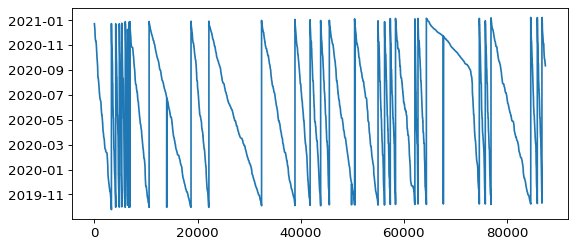

In [50]:
all_headlines_df['versionCreated'].plot()

In [41]:
quasi_logger

,ric_i,ric_now,headlines_slice_i,headlines_number,up_to_date_ric,story_i,story_id_now,story_is_success,date_time
0,0,DTEGn.DE,0,100,2020-12-24T03:51:28,0,urn:newsml:reuters.com:20201223:nNRAdspppv:1,True,2020-12-24 03:51:31.939240
1,0,DTEGn.DE,0,100,2020-12-24T03:51:28,1,urn:newsml:reuters.com:20201222:nGLF4Kt1L3:2,True,2020-12-24 03:51:33.740708
2,0,DTEGn.DE,0,100,2020-12-24T03:51:28,2,urn:newsml:reuters.com:20201222:nGLF2DBhZz:2,True,2020-12-24 03:51:37.079818
3,0,DTEGn.DE,0,100,2020-12-24T03:51:28,3,urn:newsml:reuters.com:20201221:nBw3VPZ4Qa:1,True,2020-12-24 03:51:37.803316
4,0,DTEGn.DE,0,100,2020-12-24T03:51:28,4,urn:newsml:reuters.com:20201219:nL8N2IY3D9:1,True,2020-12-24 03:51:38.957981
...,...,...,...,...,...,...,...,...,...
53819,11,HNKG_p.DE,4,100,2020-07-07 09:42:59+00:00,99,urn:newsml:reuters.com:20200520:nNRAbucabw:1,True,2021-01-05 05:41:53.336412
53820,8,BMWG.DE,0,100,2019-10-06 15:27:42.674000+00:00,0,urn:newsml:reuters.com:20191006:nNDL48zr3x:1,True,2021-01-05 16:18:51.638037
53821,9,BAYGn.DE,0,1,2019-10-05 18:25:44.765000+00:00,0,urn:newsml:newsroom:20191005:nNRA9vs5t6:0,True,2021-01-05 16:19:14.101785
53822,10,IFXGn.DE,0,1,2019-10-07 10:00:00+00:00,0,urn:newsml:reuters.com:20191007:nL5N26S21Z:2,True,2021-01-05 16:19:34.249821


In [51]:
# Сохранить версию all_headlines_df
file_version = 1
folder_name = path_project_folder + folder_name_headlines
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'all_headlines_df' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
# C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2020-12-24_v6.csv
file_path = folder_name + file_name
all_headlines_df.to_csv(file_path, sep = '~', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/backup_headlines/all_headlines_df_2021-01-08_v6.csv


In [40]:
# Сохранить версию логгера
file_version = 1
folder_name = path_project_folder + folder_name_logger
date_now = datetime.today().strftime("%Y-%m-%d")
file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
while file_name in os.listdir(folder_name):
    file_name = 'quasi_logger' + '_' + str(date_now) + '_v' + str(file_version) + '.csv'
    file_version = file_version + 1
file_path = folder_name + file_name
quasi_logger.to_csv(file_path, sep = ';', index=False)
print(file_path)

C:/DAN/t_systems/trade_project/logger/quasi_logger_2021-01-08_v5.csv


In [32]:
print('df shape:', all_headlines_df.shape, ',  Num of rics:', all_headlines_df.groupby('ric')['ric'].nunique().sort_values(ascending=False).count())
print('StoryId duplicated:', all_headlines_df['storyId'].duplicated().sum())
print('Rows in df duplicated:', all_headlines_df.duplicated().sum())
print()
print('status error_when_trying_to_collect_story:', all_headlines_df[all_headlines_df['story'] == 'error_when_trying_to_collect_story']['story'].count())
print()
print('    Number of NA:')
print(len(all_headlines_df) - all_headlines_df.notna().sum())

df shape: (77560, 6) ,  Num of rics: 29
StoryId duplicated: 9541
Rows in df duplicated: 866

status error_when_trying_to_collect_story: 513

    Number of NA:
ric                 0
versionCreated      0
headline            0
storyId             0
sourceCode          0
story             153
dtype: int64
